In [31]:
from scripts.utils import *
from scripts.mlp_utils import *
import matplotlib.pyplot as plt

In [32]:
with open('data/schizo_genes_filtered.txt', 'r') as file:
    genes = [line.strip() for line in file]

In [33]:
with open("genept/GenePT_gene_embedding_ada_text.pickle", "rb") as f:
    embedding_dict = pickle.load(f)

In [34]:
from sklearn.decomposition import PCA
import numpy as np

# Convert embeddings to a numpy array
embeddings_matrix = np.array([embedding_dict[gene] for gene in genes if gene in embedding_dict])

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
principal_components = pca.fit_transform(embeddings_matrix)

# Print or visualize the results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)


Explained variance ratio: [0.04842688 0.03937585]
Principal components shape: (324, 2)


In [35]:
embeddings_matrix.shape

(324, 1536)

Variance explained by each component: [0.04842688 0.03937585]


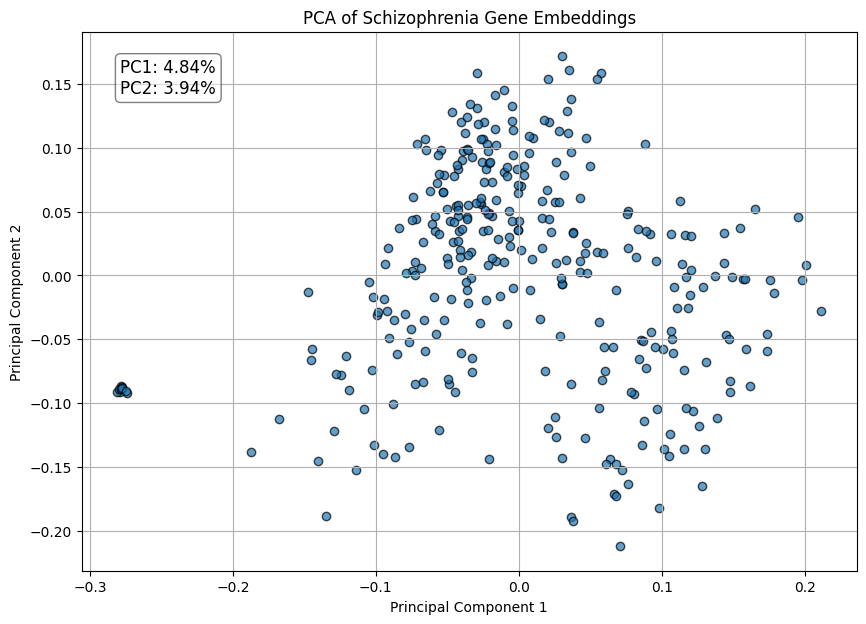

In [36]:
# Print the variance each principal component explains
print("Variance explained by each component:", pca.explained_variance_ratio_)

# Annotate the variance explained on the graph
variance_explained = pca.explained_variance_ratio_ * 100
plt.figure(figsize=(10, 7))
plt.text(0.05, 0.95, f"PC1: {variance_explained[0]:.2f}%\nPC2: {variance_explained[1]:.2f}%", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7, edgecolors='k')
plt.title('PCA of Schizophrenia Gene Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [96]:

model = MLP(input_dim=3072, hidden_dim=256)
model.load_state_dict(torch.load("models/mlp_tuned_model.pth"))

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

gene1 = genes[0]
gene2 = genes[324]

predict_epistatic(model, gene1, gene2, embedding_dict)

2.012719960475806e-05

In [97]:
print(model)

MLP(
  (ffm): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [38]:
model()

TypeError: MLP.forward() missing 1 required positional argument: 'x'

In [ ]:
from itertools import combinations
from scipy.spatial.distance import euclidean
from scipy.stats import linregress

def plot_all_gene_combos_distance_vs_prediction(genes, model, embedding_dict):
    filtered_genes = [gene for gene in genes if gene in embedding_dict]
    embeddings_matrix = np.array([embedding_dict[gene] for gene in filtered_genes])
    pca = PCA(n_components=2)  # Reduce to 2 principal components
    principal_components = pca.fit_transform(embeddings_matrix)

    distances = []
    prediction_scores = []
    gene_pairs = []

    device = torch.device("cpu")
    model.to(device)    

    # Iterate over all combinations of gene pairs
    for gene1, gene2 in combinations(filtered_genes, 2):
        if gene1 in embedding_dict and gene2 in embedding_dict:
            if gene1 != gene2:
                # Get the PCA coordinates of the two genes
                gene1_pca = principal_components[filtered_genes.index(gene1)]
                gene2_pca = principal_components[filtered_genes.index(gene2)]

                # Calculate the Euclidean distance between the two genes in PCA space
                distance = euclidean(gene1_pca, gene2_pca)

                # Predict the epistatic interaction score using the model
                gene1_embedding = embedding_dict[gene1]
                gene2_embedding = embedding_dict[gene2]
                input_vector = np.concatenate([gene1_embedding, gene2_embedding]).reshape(1, -1)
                prediction_score = model(torch.tensor(input_vector, dtype=torch.float32)).item()

                # Store the results
                distances.append(distance)
                prediction_scores.append(prediction_score)
                gene_pairs.append((gene1, gene2))

    # Plot the distance vs prediction score
    plt.figure(figsize=(10, 7))
    plt.scatter(distances, prediction_scores, alpha=0.7, color='blue', label='Data points')

    # Add a regression line
    slope, intercept, r_value, p_value, std_err = linregress(distances, prediction_scores)
    regression_line = [slope * x + intercept for x in distances]
    plt.plot(distances, regression_line, color='red', label=f'Regression line (R²={r_value**2:.2f})')

    plt.title('Distance vs Prediction Score for All Gene Pairs')
    plt.xlabel('Distance in PCA Space')
    plt.ylabel('Prediction Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return distances, prediction_scores, gene_pairs

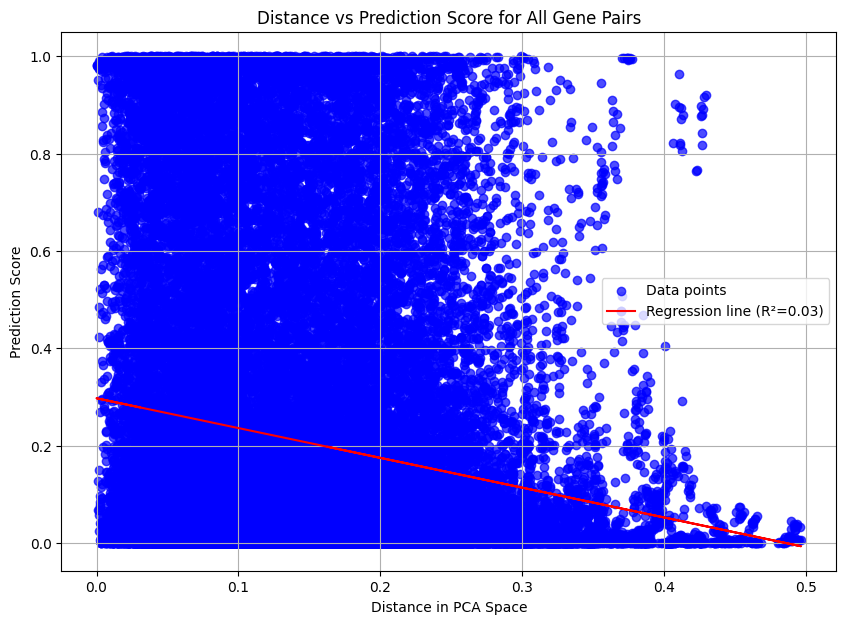

([0.16305279893245006,
  0.22876329295462808,
  0.15964329005983396,
  0.2149632687256291,
  0.17701396292188645,
  0.12762514098929037,
  0.17695336896589467,
  0.13154319463346975,
  0.15149756536989337,
  0.19426190615007227,
  0.05476076103127858,
  0.1256051122021325,
  0.13851714038247617,
  0.16375076709573166,
  0.23072698174525885,
  0.19197842855824107,
  0.15727967683877872,
  0.1525188971268514,
  0.05299078187466098,
  0.16817892867992135,
  0.10687011433623399,
  0.17568022979121847,
  0.18681505021899064,
  0.1927300416036222,
  0.26866091872070047,
  0.1575053700137638,
  0.023597496033883343,
  0.09600714446669557,
  0.13240084897976015,
  0.16333483004032254,
  0.10493340930868159,
  0.1367904560056129,
  0.0945041327680244,
  0.1835662584552746,
  0.19757617168782038,
  0.1454828587683535,
  0.1380454518199089,
  0.08544365973558307,
  0.051455786334507835,
  0.057551384910647645,
  0.05777198553029927,
  0.052108165142708725,
  0.1249694896155713,
  0.12052464967419

In [ ]:
plot_all_gene_combos_distance_vs_prediction(genes, model, embedding_dict)

In [ ]:
schizo_graph = load_graph("graphs/schizo_graph.gml")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Assuming `existing_edges` is a list of edges already in the graph
existing_edges = set(schizo_graph.edges())

# Predicted edges
predicted_edges = set()

# Filter the genes to only those present in the embedding dictionary
filtered_genes = [gene for gene in genes if gene in embedding_dict]

# Iterate over all combinations of gene pairs
for gene1, gene2 in combinations(filtered_genes, 2):
    if gene1 == gene2:
        continue  # Skip self-loops

    # Get embeddings for the gene pair
    gene1_embedding = embedding_dict[gene1]
    gene2_embedding = embedding_dict[gene2]
    input_vector = np.concatenate([gene1_embedding, gene2_embedding]).reshape(1, -1)

    # Predict the epistatic interaction score
    prediction_score = model(torch.tensor(input_vector, dtype=torch.float32)).item()

    # Add an edge if the prediction score is above 0.9
    if prediction_score > 0.6:
        predicted_edges.add((gene1, gene2))
        if (gene1, gene2) not in existing_edges or (gene2, gene1) not in existing_edges:
            schizo_graph.add_edge(gene1, gene2, weight=prediction_score, color=0)
        

# Print the number of edges added
print(f"Pred: {len(predicted_edges)}")
print(f"Existing: {len(existing_edges)}")

Pred: 7218
Existing: 7352


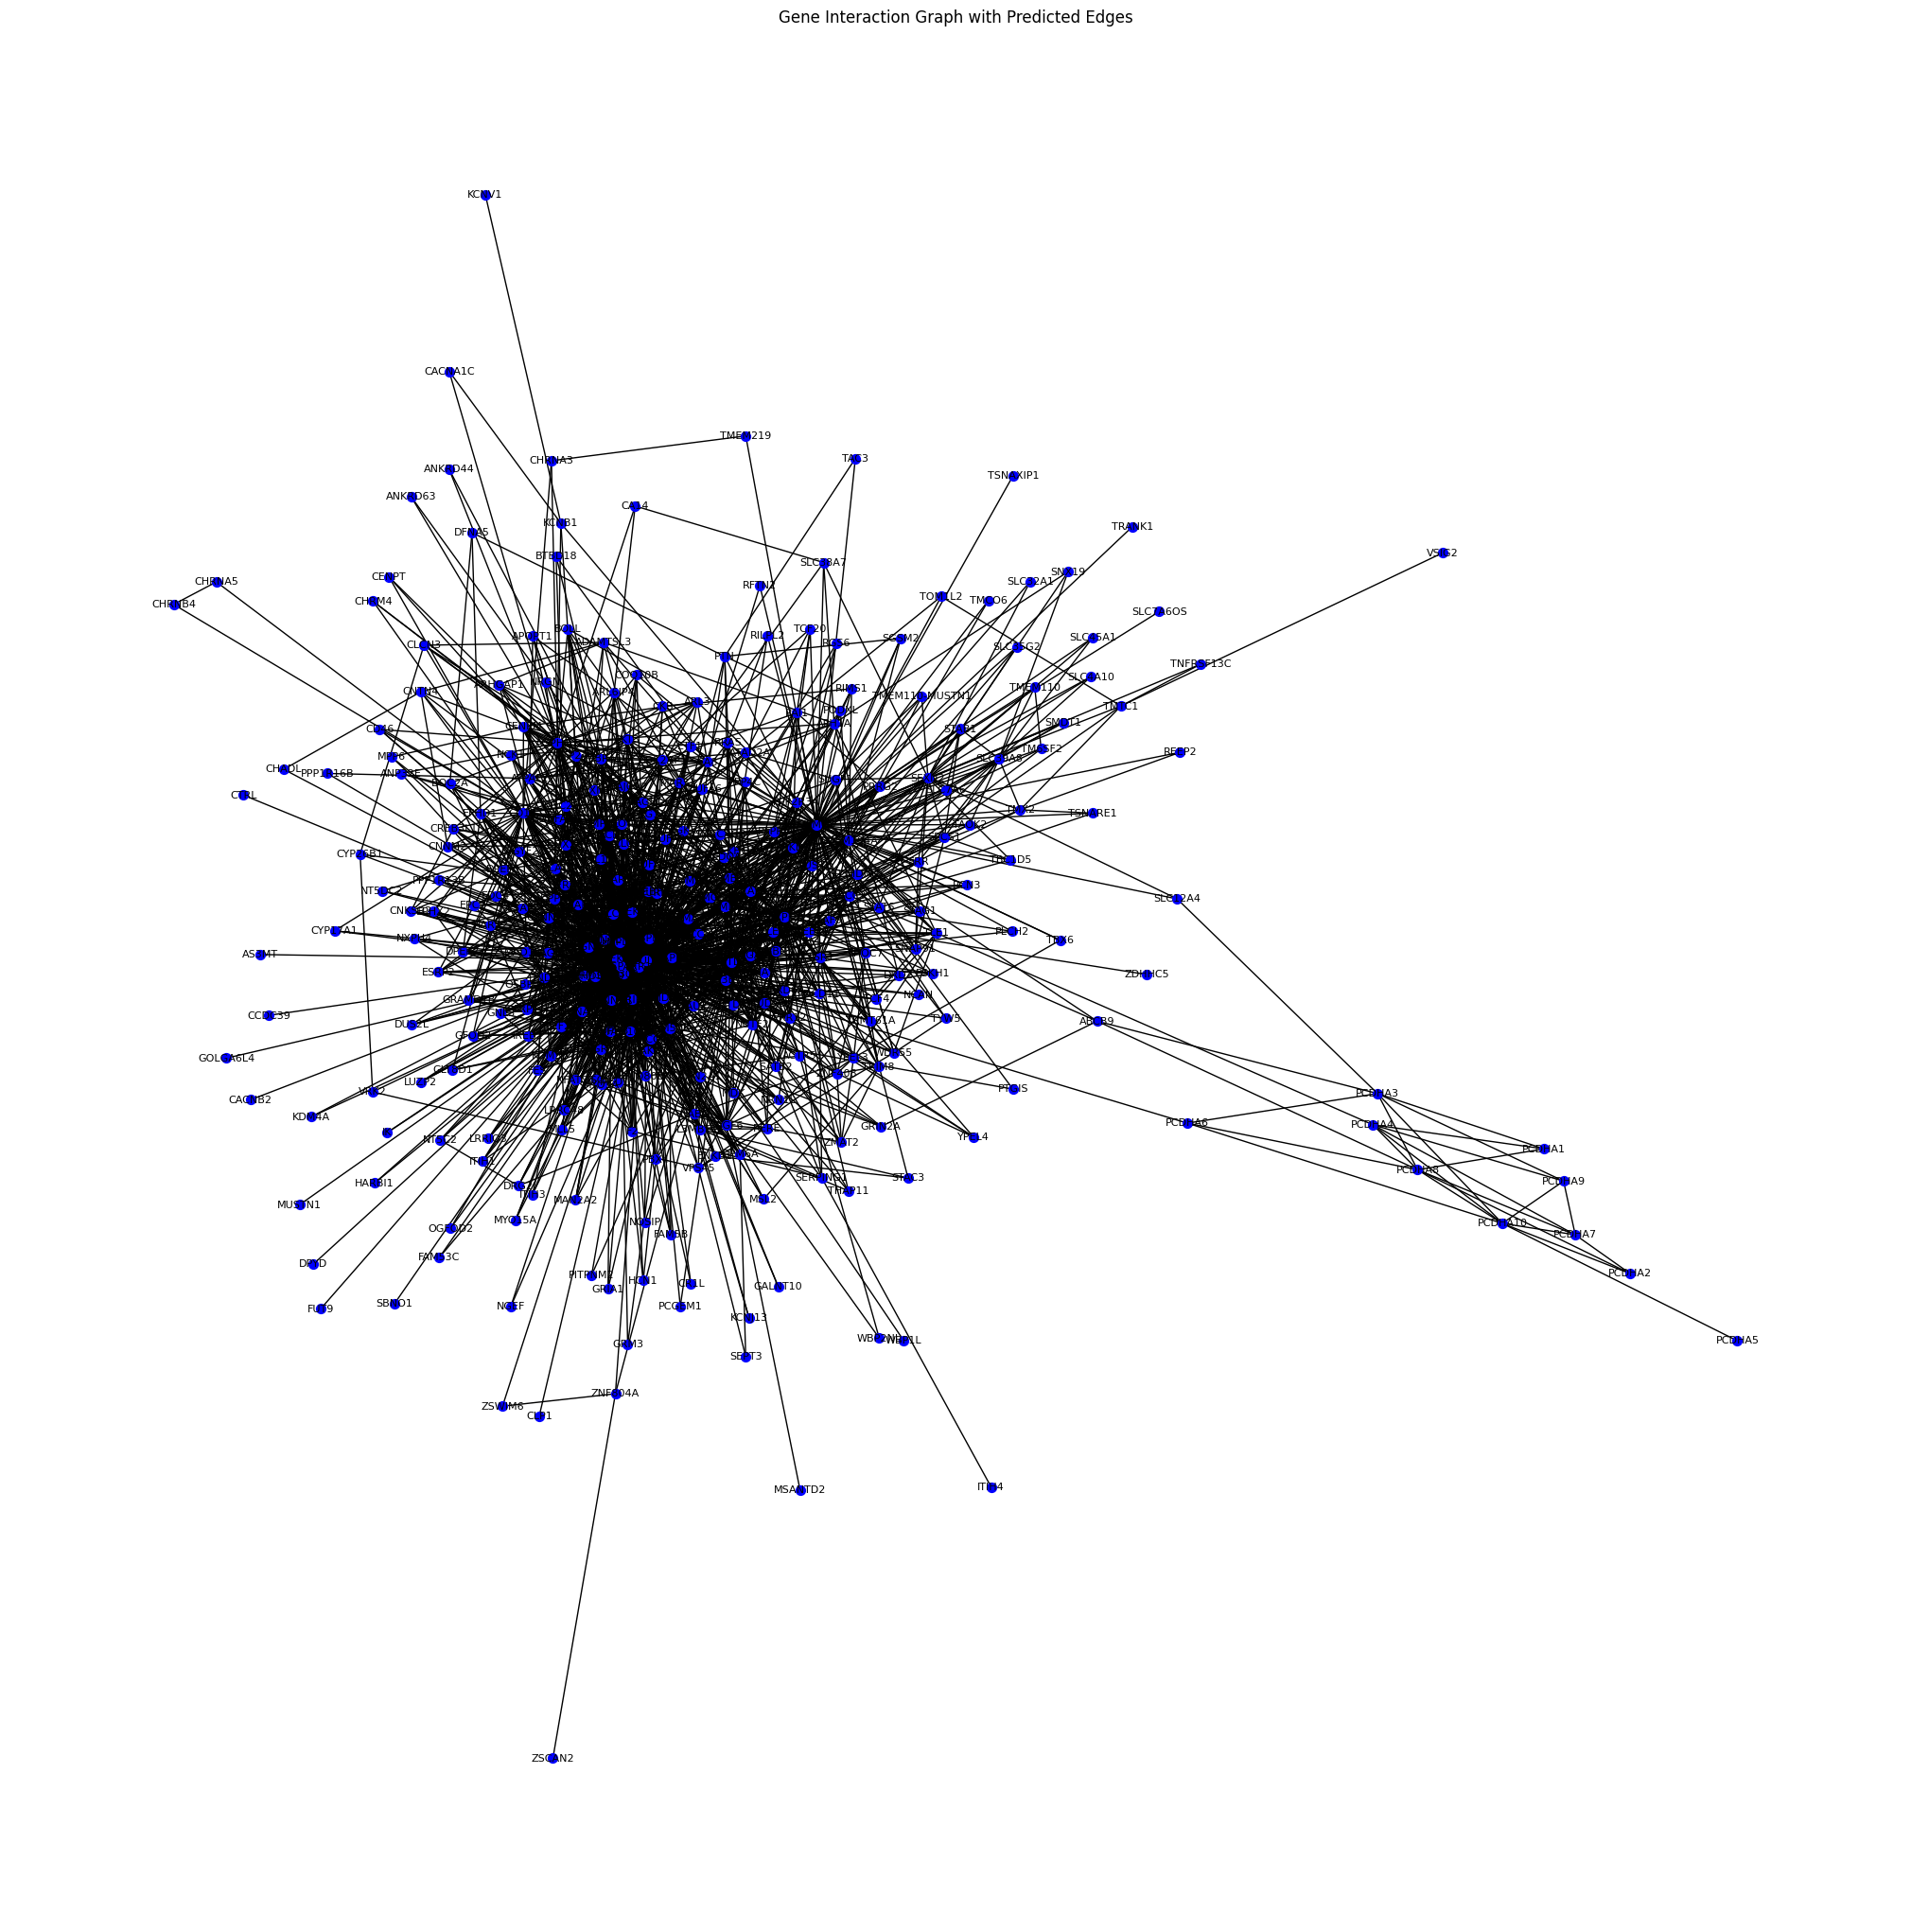

In [ ]:
# I want to display the graph
plot_graph(schizo_graph, title="Gene Interaction Graph with Predicted Edges")

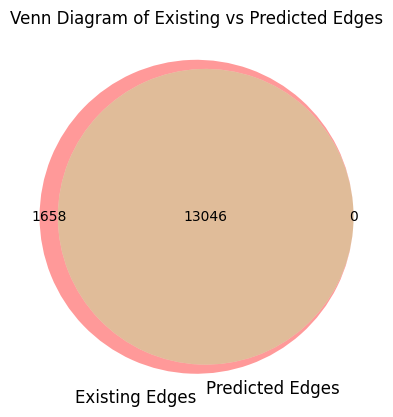

In [ ]:
# Create a Venn diagram
# Add edges both directions for example if (gene1, gene2) is in existing_edges, add (gene2, gene1) too
bi_existing_edges = existing_edges | {(gene2, gene1) for gene1, gene2 in existing_edges}
bi_predicted_edges = predicted_edges | {(gene2, gene1) for gene1, gene2 in predicted_edges}

venn2([bi_existing_edges, bi_predicted_edges], ('Existing Edges', 'Predicted Edges'))
plt.title("Venn Diagram of Existing vs Predicted Edges")
plt.show()


In [ ]:
predicted_not_in_existing = predicted_edges - existing_edges


In [ ]:
predicted_not_in_existing

with open("graphs/predicted_not_in_existing.txt", "w") as f:
    for edge in predicted_not_in_existing:
        f.write(f"{edge[0]}\t{edge[1]}\n")

# Run on Sage

In [82]:
from scripts.gnn_utils import *
import torch_geometric as pyg
from torch_geometric.data import Data

In [110]:
model_constructor_args_sage = {
'in_channels': 1536,
'hidden_channels': 256,
'out_channels': 16,
'conv_type': 'SAGE' 
}
model = GraphiStasis(**model_constructor_args_sage)
# model.load_state_dict(torch.load("models/SAGE.pt", map_location=torch.device('mps')))

In [85]:
def prepare_schizo_data(graph: nx.Graph) -> Data:
    """
    Prepare the data for GNN link prediction.
    Returns a PyTorch Geometric Data object.
    """

    # Unpickle embedding dict file (read-binary mode)
    with open("genept/GenePT_gene_embedding_ada_text.pickle", "rb") as f:
        gene_embedding_dict = pickle.load(f)

    # Convert NetworkX graph to PyTorch Geometric Data object
    graph = nx.convert_node_labels_to_integers(graph)
    pyg_data = pyg.utils.from_networkx(graph)

    # Keep track of graph attributes
    node_type_list = []
    idx_to_gene = {}
    idx_to_disease = {}
    embedding_dim = len(next(iter(gene_embedding_dict.values())))
    embeddings = []
    for idx, (n, d) in enumerate(graph.nodes(data=True)):
        node_type = d.get('node_type', None) or d.get('type', None)
        node_type_list.append(node_type)
        node_name = d.get('name', str(n))
        if node_type == 1:
            idx_to_gene[idx] = node_name
            emb = gene_embedding_dict.get(node_name, np.zeros(embedding_dim))
        if node_type == 2:
            idx_to_disease[idx] = node_name
            emb = np.zeros(embedding_dim)
        embeddings.append(emb)
    print("Idx -> [Gene, Disease] mapping done")
    pyg_data.x = torch.tensor(np.stack(embeddings), dtype=torch.float32)
    print("After setting embeddings, x shape:", pyg_data.x.shape)

    # Debug prints
    try:
        print("x.shape[0]:", pyg_data.x.shape[0])
        print("edge_index.max():", pyg_data.edge_index.max())
        if pyg_data.x.shape[0] < pyg_data.edge_index.max():
            print("Warning: Edge indices reference node indices not in feature matrix.")
        else:
            print("Aight ur chillin prolly")
    except Exception as e:
        print("Error in prepare_data print statements:", e)

    if hasattr(pyg_data, 'name'): del pyg_data.name

    if not hasattr(pyg_data, 'name'): print("Name removed from pyg_data")
    print(pyg_data)

    return pyg_data, [node_type_list, idx_to_gene, idx_to_disease]


In [93]:
schizo_graph = load_graph("graphs/schizo_graph.gml")

schizo_pyg, schizo_others = prepare_schizo_data(schizo_graph)

Idx -> [Gene, Disease] mapping done
After setting embeddings, x shape: torch.Size([209, 1536])
x.shape[0]: 209
edge_index.max(): tensor(208)
Aight ur chillin prolly
Name removed from pyg_data
Data(edge_index=[2, 730], node_type=[209], num_nodes=209, x=[209, 1536])


In [ ]:
selected = predict_gene_gene_links(model, schizo_pyg, schizo_others[0], schizo_others[1], save_path="predictions/schizo_gene_gene_links.txt")



AttributeError: 'collections.OrderedDict' object has no attribute 'eval'